<a href="https://colab.research.google.com/github/rohan-pradhan/BitPlaneSlicingAdversarialDefense/blob/master/model_nonsliced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

    100% |████████████████████████████████| 51kB 4.6MB/s 


In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import os
from google.colab import drive
drive.mount('/content/drive')


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Data

In [0]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False
num_predictions = 20
save_dir = "/content/drive/My Drive/ECE1512-FinalProject/saved_models"
full_file = save_dir+"/test.txt"
    
print (save_dir)
model_name = 'keras_cifar10_trained_model_nonsliced.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




/content/drive/My Drive/ECE1512-FinalProject/saved_models
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Model


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



# Bit Plane Slicing Pre Processor

In [0]:

def slice(x, numb_bits):  
  i = np.full(x.shape, numb_bits)
  #print(t.shape,i.shape)
  t = x&i
  #print(np.unique(t))
  #print(t.shape)
  return t

# x_test = slice(x_test)
# x_test = x_test.astype('float32')

# x_train /= 255
# x_test /= 255


# Model Training

In [0]:

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)




[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254]
(10000, 32, 32, 3)
Not using data augmentation.


NameError: ignored

In [0]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Evaluation


First, we will upload the trained model


In [0]:
classifier = tf.keras.models.load_model("keras_cifar10_trained_model_nonsliced.h5")

## Evaluation with Clean Examples

In [0]:
clean_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test_slice = x_test
  x_test_slice *= 255
  x_test_slice = x_test.astype('int')
  x_test_slice = slice(x_test, i)
  x_test_slice = x_test_slice.astype('float32')
  x_test_slice /= 255
  acc = classifier.evaluate(x_test_slice, y_test)
  clean_accs.append(acc[1])

Testing with  100  bits
10000/10000 [==============================] - 1s 143us/sample - loss: 2.2532 - acc: 0.2110
Testing with  101  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 1.9549 - acc: 0.3005
Testing with  102  bits
10000/10000 [==============================] - 2s 150us/sample - loss: 2.2490 - acc: 0.2117
Testing with  103  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 1.9521 - acc: 0.3006
Testing with  104  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.2440 - acc: 0.2137
Testing with  105  bits
10000/10000 [==============================] - 2s 153us/sample - loss: 1.9415 - acc: 0.3080
Testing with  106  bits
10000/10000 [==============================] - 2s 152us/sample - loss: 2.2397 - acc: 0.2153
Testing with  107  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 1.9376 - acc: 0.3102
Testing with  108  bits
10000/10000 [==============================] - 2

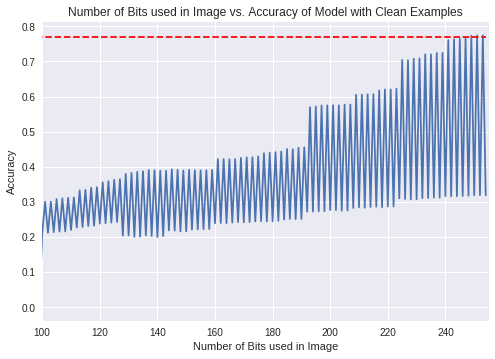

In [0]:
x = [0]*100
accs_copy = clean_accs
x_adv = [0.77]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with Clean Examples')
plt.xlim(100, 255)
plt.show()

##  CW Attack Evaluation with Slicing Defense


### Learning Rate: 0.07

In [0]:
CW_LR_07_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_CW_LR_07.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  CW_LR_07_accs.append(acc[1])


Testing with  100  bits
10000/10000 [==============================] - 2s 155us/sample - loss: 2.1764 - acc: 0.1967
Testing with  101  bits
10000/10000 [==============================] - 2s 167us/sample - loss: 2.1748 - acc: 0.1964
Testing with  102  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 2.1738 - acc: 0.1970
Testing with  103  bits
10000/10000 [==============================] - 2s 167us/sample - loss: 2.1722 - acc: 0.1982
Testing with  104  bits
10000/10000 [==============================] - 2s 168us/sample - loss: 2.1755 - acc: 0.1972
Testing with  105  bits
10000/10000 [==============================] - 2s 166us/sample - loss: 2.1741 - acc: 0.1967
Testing with  106  bits
10000/10000 [==============================] - 2s 167us/sample - loss: 2.1730 - acc: 0.1985
Testing with  107  bits
10000/10000 [==============================] - 2s 165us/sample - loss: 2.1717 - acc: 0.1983
Testing with  108  bits
10000/10000 [==============================] - 2

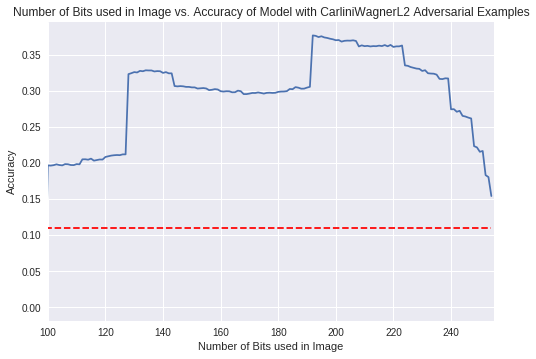

In [0]:
x = [0]*100
accs_copy = CW_LR_07_accs
x_adv = [0.11]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(100, 255)
plt.show()


## FGSM Attack Evaluation Using Slicing Defense



### Epsilon 0.005


In [0]:
FGSM_005_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_005.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_005_accs.append(acc[1])

Testing with  100  bits
10000/10000 [==============================] - 1s 143us/sample - loss: 2.0326 - acc: 0.2663
Testing with  101  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0318 - acc: 0.2659
Testing with  102  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0318 - acc: 0.2667
Testing with  103  bits
10000/10000 [==============================] - 1s 150us/sample - loss: 2.0310 - acc: 0.2672
Testing with  104  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0268 - acc: 0.2675
Testing with  105  bits
10000/10000 [==============================] - 2s 151us/sample - loss: 2.0256 - acc: 0.2678
Testing with  106  bits
10000/10000 [==============================] - 2s 152us/sample - loss: 2.0259 - acc: 0.2686
Testing with  107  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0249 - acc: 0.2670
Testing with  108  bits
10000/10000 [==============================] - 2

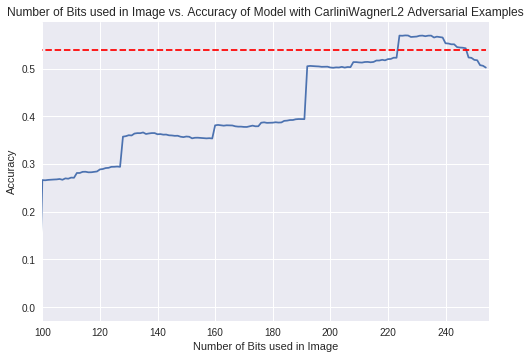

In [0]:
x = [0]*100
accs_copy = FGSM_005_accs
x_adv = [0.539]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(100, 255)
plt.show()

### Epsilon 0.009


In [0]:
FGSM_009_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_009.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_009_accs.append(acc[1])

Testing with  100  bits
10000/10000 [==============================] - 1s 145us/sample - loss: 2.0780 - acc: 0.2425
Testing with  101  bits
10000/10000 [==============================] - 2s 152us/sample - loss: 2.0770 - acc: 0.2433
Testing with  102  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0768 - acc: 0.2435
Testing with  103  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0761 - acc: 0.2434
Testing with  104  bits
10000/10000 [==============================] - 2s 153us/sample - loss: 2.0802 - acc: 0.2397
Testing with  105  bits
10000/10000 [==============================] - 2s 150us/sample - loss: 2.0795 - acc: 0.2411
Testing with  106  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.0786 - acc: 0.2408
Testing with  107  bits
10000/10000 [==============================] - 2s 151us/sample - loss: 2.0782 - acc: 0.2404
Testing with  108  bits
10000/10000 [==============================] - 2

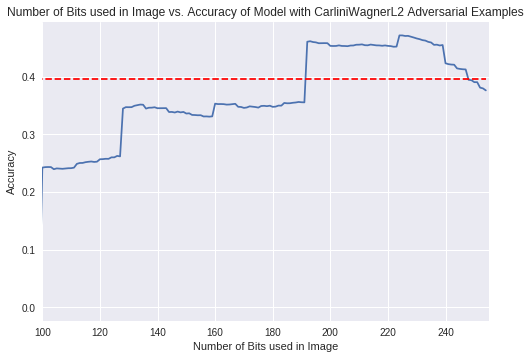

In [0]:
x = [0]*100
accs_copy = FGSM_009_accs
x_adv = [0.3957]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(100, 255)
plt.show()

### Epsilon 0.02


In [0]:
FGSM_02_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_02.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_02_accs.append(acc[1])

Testing with  100  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.2008 - acc: 0.1908
Testing with  101  bits
10000/10000 [==============================] - 2s 152us/sample - loss: 2.2002 - acc: 0.1909
Testing with  102  bits
10000/10000 [==============================] - 2s 154us/sample - loss: 2.2008 - acc: 0.1903
Testing with  103  bits
10000/10000 [==============================] - 1s 150us/sample - loss: 2.2003 - acc: 0.1896
Testing with  104  bits
10000/10000 [==============================] - 1s 150us/sample - loss: 2.2038 - acc: 0.1888
Testing with  105  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.2032 - acc: 0.1898
Testing with  106  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.2037 - acc: 0.1876
Testing with  107  bits
10000/10000 [==============================] - 2s 151us/sample - loss: 2.2031 - acc: 0.1886
Testing with  108  bits
10000/10000 [==============================] - 1

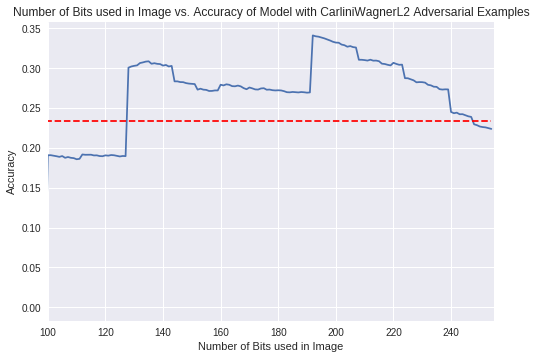

In [0]:
x = [0]*100
accs_copy = FGSM_02_accs
x_adv = [0.2339]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(100, 255)
plt.show()

### Epsilon 0.04

In [0]:
FGSM_04_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_04.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_04_accs.append(acc[1])

Testing with  100  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.3100 - acc: 0.1540
Testing with  101  bits
10000/10000 [==============================] - 2s 151us/sample - loss: 2.3094 - acc: 0.1536
Testing with  102  bits
10000/10000 [==============================] - 2s 153us/sample - loss: 2.3090 - acc: 0.1529
Testing with  103  bits
10000/10000 [==============================] - 2s 154us/sample - loss: 2.3088 - acc: 0.1531
Testing with  104  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.3148 - acc: 0.1514
Testing with  105  bits
10000/10000 [==============================] - 1s 150us/sample - loss: 2.3149 - acc: 0.1510
Testing with  106  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.3153 - acc: 0.1499
Testing with  107  bits
10000/10000 [==============================] - 2s 150us/sample - loss: 2.3155 - acc: 0.1502
Testing with  108  bits
10000/10000 [==============================] - 1

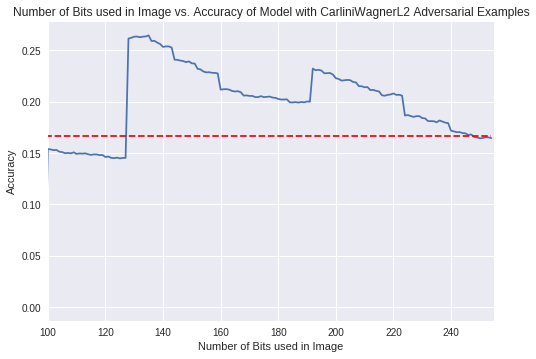

In [0]:
x = [0]*100
accs_copy = FGSM_04_accs
x_adv = [0.1665]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(100, 255)
plt.show()

### Epsilon 0.07

In [0]:
FGSM_07_accs = []
for i in range(100, 255):
  print ("Testing with ", i, " bits")
  x_test = np.load('attack_images_np_FGSM_eps_07.npy')
  x_test *= 255
  x_test = x_test.astype('int')
  x_test = slice(x_test, i)
  x_test = x_test.astype('float32')
  x_test /= 255
  acc = classifier.evaluate(x_test, y_test)
  FGSM_07_accs.append(acc[1])

Testing with  100  bits
10000/10000 [==============================] - 2s 152us/sample - loss: 2.3566 - acc: 0.1343
Testing with  101  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.3559 - acc: 0.1348
Testing with  102  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.3558 - acc: 0.1337
Testing with  103  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.3552 - acc: 0.1339
Testing with  104  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.3534 - acc: 0.1349
Testing with  105  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.3528 - acc: 0.1355
Testing with  106  bits
10000/10000 [==============================] - 1s 148us/sample - loss: 2.3527 - acc: 0.1355
Testing with  107  bits
10000/10000 [==============================] - 1s 149us/sample - loss: 2.3522 - acc: 0.1346
Testing with  108  bits
10000/10000 [==============================] - 1

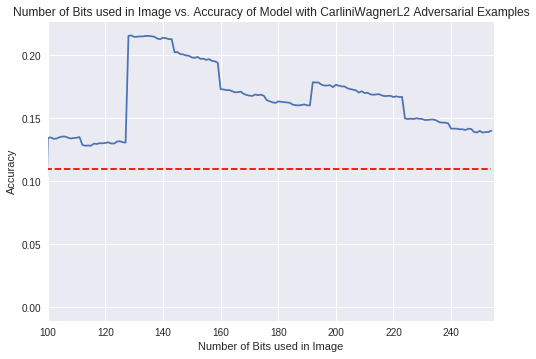

In [0]:
x = [0]*100
accs_copy = FGSM_07_accs
x_adv = [0.11]*255
# accs_copy = x
accs_copy = x+accs_copy
import matplotlib.pyplot as plt
plt.plot(accs_copy)
plt.plot(x_adv, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Number of Bits used in Image')
plt.title('Number of Bits used in Image vs. Accuracy of Model with CarliniWagnerL2 Adversarial Examples')
plt.xlim(100, 255)
plt.show()